In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

## **LOADING DATASET**

Dataset of ad clicks from Taobao obtained from https://github.com/openbenchmark/BARS/tree/master/ctr_prediction/datasets/Taobao

The dataset is provided by Alibaba, which contains 8 days of ad click logs that are randomly sampled from 1140000 users at the website of Taobao. The dataset has a total of 26 million records while in this work we will use only the first 5 million for demonstration of the MAB methods, representing rougly 1.5 days.

In [2]:
dataset = pd.read_csv('Taobao/train.csv')
take_first_N_values = 5000000
dataset = dataset.head(take_first_N_values)

# **1. EXPLORING AND PROCESSING** 
## **Dataset overview**

Summary of the dataset: Records represent ads shown to users at different times. 
Fields:
- **clk**: 1/0 if user clicked on the ad or not. This field be used as the discrete rewards for our agent.
- **cate_id,campaign_id,customer,brand,price**: As per the Alibaba description: "One of the ad ID corresponds to an item, an item belongs to a category, an item belongs to a brand". Therefore this field represents different categories of ads that will serve as arms for our MAB problem.
- The rest of the fields are features that the agent observes and uses to predict which ad to show for the best reward (user clicking on the ad). 

Bellow is the summary of the first 5 records:

In [3]:
dataset.head()

,clk,time_stamp,userid,adgroup_id,pid,cate_id,campaign_id,customer,brand,price,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,click_sequence
0,0,2017-05-06 00:00:00,874257,172298,430548_1007,5443,160194,864,339907.0,3.9,0.0,3.0,2.0,3.0,NaN,3.0,0.0,NaN,NaN
1,0,2017-05-06 00:00:00,227368,519384,430548_1007,6261,137739,1210,158849.0,189.0,0.0,4.0,2.0,4.0,NaN,3.0,0.0,NaN,NaN
2,0,2017-05-06 00:00:00,626053,513129,430539_1007,6251,264355,214436,58727.0,168.0,0.0,2.0,2.0,2.0,NaN,3.0,0.0,NaN,NaN
3,0,2017-05-06 00:00:00,549940,659142,430539_1007,7212,366810,254969,180856.0,159.0,44.0,5.0,2.0,5.0,2.0,3.0,0.0,NaN,NaN
4,0,2017-05-06 00:00:00,549940,431258,430539_1007,2201,349173,22878,455009.0,98.0,44.0,5.0,2.0,5.0,2.0,3.0,0.0,NaN,NaN


## **Removing irrelevant fields**
Since **tim_stamp** and **userid** are almost distinct for each record and **pid** is an id for the scenario (based on Alibaba description) we will not use them in our model:

In [4]:
dataset = dataset.drop(['time_stamp','userid','pid'], axis=1)

## **Taking care of missing values**
First of all, it is necessary to analyze the cleanliness of the data mainly in terms of missing values. Bellow is the summary of missing value in each field of the dataset:

In [5]:
dataset.isnull().sum() / take_first_N_values

clk                     0.000000
adgroup_id              0.000000
cate_id                 0.000000
campaign_id             0.000000
customer                0.000000
brand                   0.308968
price                   0.000000
cms_segid               0.059779
cms_group_id            0.059779
final_gender_code       0.059779
age_level               0.059779
pvalue_level            0.549734
shopping_level          0.059779
occupation              0.059779
new_user_class_level    1.000000
click_sequence          0.608140
dtype: float64

It seems that **brand** of the ad shown, **pvalue_level** (Consumption grade), **new_user_class_level** (City level) and **click_sequence** (historical behaviour) are significantly affected by missing values and at the same time are not the features we would need to use in our model. Therefore we discard them completely:

In [6]:
dataset = dataset.drop(['brand','pvalue_level','new_user_class_level','click_sequence'], axis=1)

Finally, the rest of the fields with missing values represent only 6% of the record. One option would be to replace them by a random value from a distribution that would conserve the feature statistics. However, all the features with missing values seem to have the same frequency, which means they are probably the same records. Our assumption is that these are somehow corrupted and therefore we discard those records completely. The following code proves that these are the same records:

In [7]:
dataset = dataset.dropna(subset=['cms_segid'])
dataset.isnull().sum() / take_first_N_values

clk                  0.0
adgroup_id           0.0
cate_id              0.0
campaign_id          0.0
customer             0.0
price                0.0
cms_segid            0.0
cms_group_id         0.0
final_gender_code    0.0
age_level            0.0
shopping_level       0.0
occupation           0.0
dtype: float64

## **Selecting a set of actions**
At this point we need to select which feature will represent the set of actions the agent can chose from. In general, this will be a feature representing the ad chosen (arm of the MAB problem). In order to reduce the complexity of the model for the sake of this presentation, we will chose the feature with the least amount of distinct values. For this we visualise the distribution of ad features in the dataset. Possible candidates for representing selected ads: **adgroup_id**, **cate_id**, **campaign_id**, **customer**,	**brand** or **price**. 

In [8]:
def show_ad_feature_distribution(dataset: pd.DataFrame) -> None:
  plt.figure(figsize=(12, 6), dpi=80)
  plt.loglog(dataset["adgroup_id"].value_counts(normalize=True).values, label="adgroup_id",linewidth=3)
  plt.loglog(dataset["cate_id"].value_counts(normalize=True).values, label="cate_id",linewidth=3)
  plt.loglog(dataset["campaign_id"].value_counts(normalize=True).values, label="campaign_id",linewidth=3)
  plt.loglog(dataset["customer"].value_counts(normalize=True).values, label="customer",linewidth=3)
  plt.loglog(dataset["price"].value_counts(normalize=True).values, label="price",linewidth=3)
  plt.xlabel('id of ad features (1-N where N is the number of distinct values)')
  plt.ylabel('Frequency in dataset')
  plt.title('Distribution of ad features that could represent the ads in the MAB problem')
  plt.legend(loc='upper right')
  plt.grid()
  plt.show()

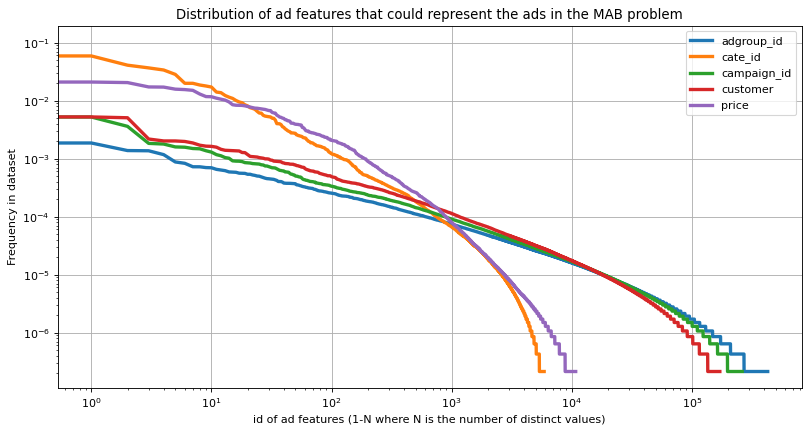

In [9]:
show_ad_feature_distribution(dataset)

This shows that the best feature to accept as our set of MAB arms is the cate_id which has the least ammount of distinct values. This corresponds to our assumption that **category** is the highest superset of ad descriptors. Therefore, we drop the rest of the features connected to ad description: 

In [10]:
dataset = dataset.drop(['adgroup_id','campaign_id','customer','price'], axis=1)

Furthermore, to reduce the complexity of the problem we choose only ads with cate_id frequency in the dataset higher than 1% in order to reduce the number of arms to 17.

In [11]:
dataset = dataset[dataset['cate_id'].map(dataset['cate_id'].value_counts(normalize=True)) > 0.01]

Now it would be helpful to know the click-through rate of each of the 17 ad categories (now defined by cate_id) to compare it later with the model. Ideally the model should be able to recognize which ad is the most succesfull for each user feature. Here we show the CTR for each ad overall, while ignoring the features.

In [12]:
def plot_CTR(dataset: pd.DataFrame) -> None:
  total = dataset['clk'].sum()/len(dataset['clk'])
  ad_freq = dataset["cate_id"].value_counts(normalize=True)
  ad_CTR = dataset.groupby(["cate_id"])['clk'].sum() / dataset.groupby(["cate_id"])["cate_id"].count()
  combined = ad_freq.to_frame().merge(ad_CTR.to_frame(), left_index=True, right_index=True)
  plt.figure(figsize=(8, 6), dpi=80)
  plt.scatter(combined.iloc[:,0],100*combined.iloc[:,1], linewidth=3)
  plt.xlabel('Frequency of selected cate_id in the dataset')
  plt.ylabel('Overall click-through rate [%]')
  plt.title(f'Total click-through rate = {100*total: 0.1f} %')
  plt.grid()
  plt.show()

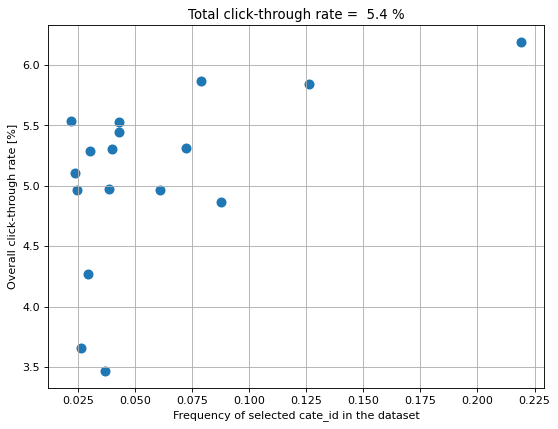

In [13]:
plot_CTR(dataset)

The best ad (ingoring user features) is the the ad with the highest frequency in the dataset and its click-through rate is 6.2%. If we assumed that the user feature are irrelevant for selecting the optimal ad, then the goal would be to train the model that achieves the total CTR of 6.2% after the selected period by selecting only this specific ad. However, user feutures will probably play a role and some ads are probably more clicked on by certain users. Now we need to choose which user feautures to select for our model.

Also, there aren't significant outliers in terms of very low frequency. There is an outlier in the highest frequency ad which shows that the dataset policy of ad selection was not random (unfortunately...).

Finally, we encode the action set from 0 to N-1 where N is the number of possible actions. This will faciliate integration with the contextbandit library.

In [14]:
from sklearn.preprocessing import LabelEncoder
le_act = LabelEncoder()
dataset['cate_id'] = le_act.fit_transform(dataset['cate_id'])
display(dataset['cate_id'].value_counts())

c:\Users\RippS\anaconda3\envs\reinforced\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


13    479709
1     276285
10    191481
3     171893
4     158086
16    132847
2      93282
6      93216
5      87106
15     83778
9      80325
7      65885
12     64276
8      57443
14     53797
0      51216
11     47155
Name: cate_id, dtype: int64

## **Selecting features for our context vector**
Fortunatly, all the features possess numerical values that can be ordered. This justifies the use of correlations directly. Otherwise, we would have to encode the features using one-hot encoding and then calculating the biserial correlation.

We can combine both Pearson and Spearman correlation matrices to discard features that have around 0.5 correlation with other features. Bellow are shown both matrices:


In [15]:
import seaborn as sns
def plot_correlation(dataset: pd.DataFrame, method: str) -> None:
  user_features_data = dataset
  correlation_mat = user_features_data.corr(method = 'pearson')
  plt.figure(figsize=(16, 12), dpi=80)
  sns.heatmap(correlation_mat, annot = True)
  plt.title(method+' correlation matrix')
  plt.show()

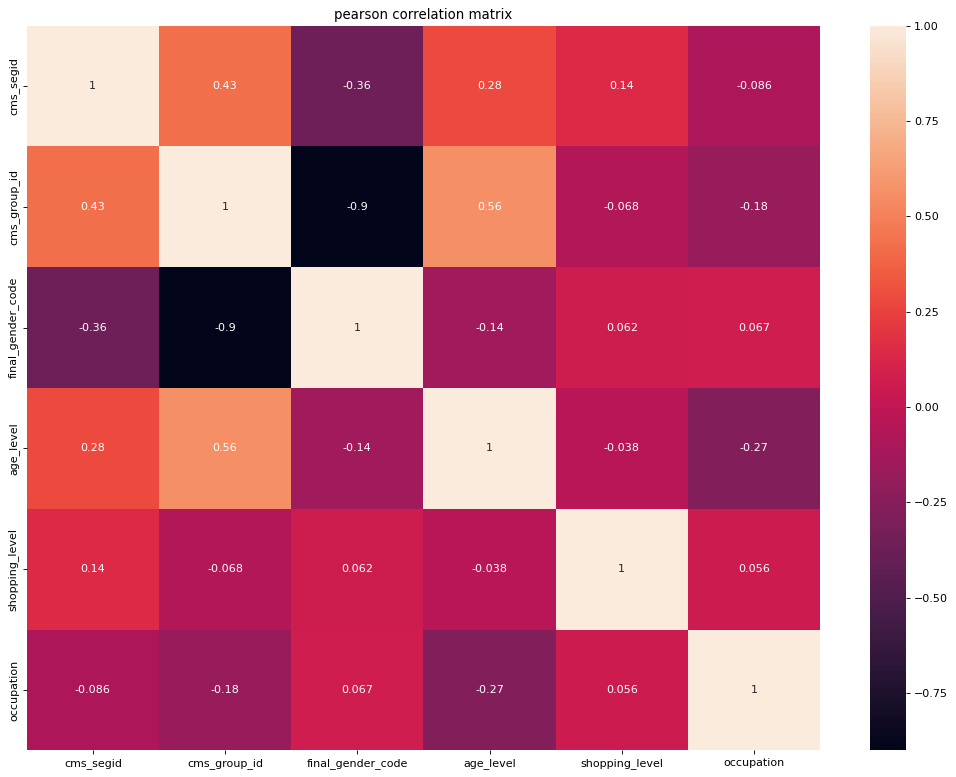

In [16]:
plot_correlation(dataset.drop(['clk',	'cate_id'], axis=1),'pearson') #not correlating clk and cate_id because these are not user features

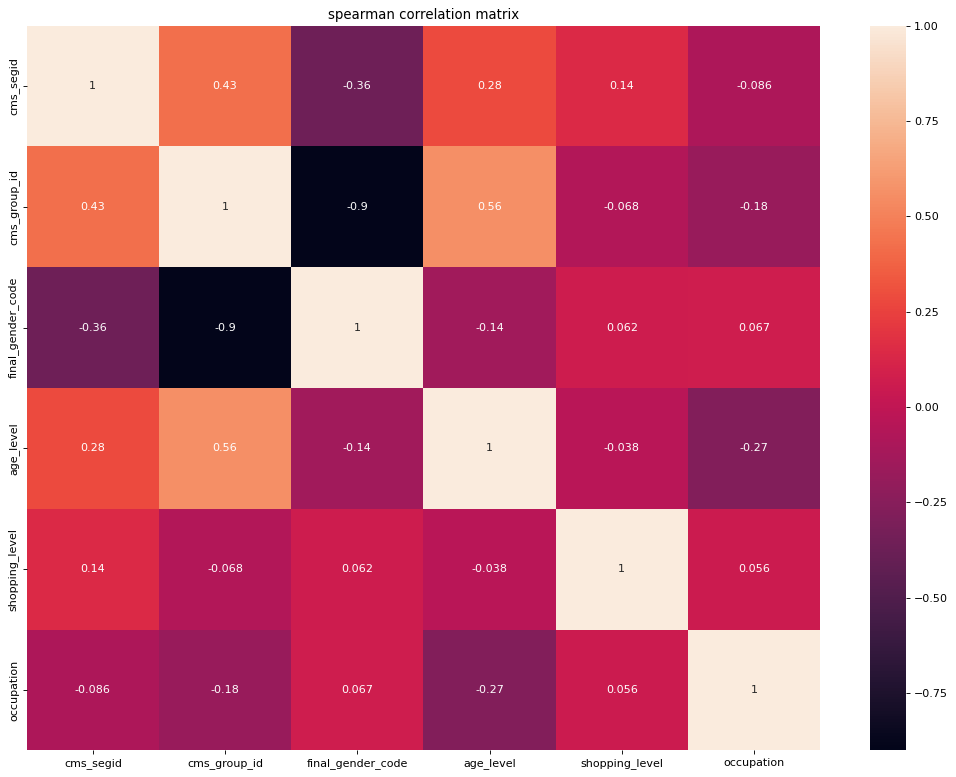

In [17]:
plot_correlation(dataset.drop(['clk',	'cate_id'], axis=1),'spearman')

It is quite clear that cms_group_id correlates strongly with final_gender_code and we can thus discard it. Another feature that exhibits >0.4 correlation is the cms_segid. Normally we would leave this feature and let the model detect its redundancy because the correlation matrices are not that conclusive. However, it is plausible that the features has similar characteristics with cms_group_id with 0.4 correlation which we discared and therefore we will discard that as well.  

In [18]:
dataset = dataset.drop(['cms_segid','cms_group_id'], axis=1)

This leaves us with the following dataset:

In [19]:
dataset.head()

,clk,cate_id,final_gender_code,age_level,shopping_level,occupation
1,0,13,2.0,4.0,3.0,0.0
6,0,5,2.0,4.0,3.0,0.0
7,0,13,2.0,3.0,3.0,0.0
8,1,13,2.0,4.0,3.0,0.0
9,0,3,2.0,2.0,3.0,0.0


## **Final check of features**
For our final check that we dont have unexpected outliers or values:

In [20]:
display(dataset['clk'].value_counts(),dataset['final_gender_code'].value_counts(),
        dataset['age_level'].value_counts(), dataset['shopping_level'].value_counts(),
        dataset['occupation'].value_counts())

0    2069512
1     118268
Name: clk, dtype: int64

2.0    1795173
1.0     392607
Name: final_gender_code, dtype: int64

3.0    665608
4.0    512709
2.0    452656
5.0    383830
1.0    140117
6.0     31962
0.0       898
Name: age_level, dtype: int64

3.0    1889290
2.0     208725
1.0      89765
Name: shopping_level, dtype: int64

0.0    2044841
1.0     142939
Name: occupation, dtype: int64

# **MAB MODEL SELECTION AND EVALUATION**
Loading the online bandit policies from contextialbandits library

In [21]:
from contextualbandits.online import BootstrappedUCB, EpsilonGreedy, BootstrappedTS, ExploreFirst 
from contextualbandits.online import EpsilonGreedy, LogisticTS, ParametricTS, LinUCB, LinTS

Initializing reward, action and feature arrays

In [22]:
rewards = dataset['clk']
actions = dataset['cate_id']
features = dataset.drop(['clk',	'cate_id'], axis=1)
print(rewards.shape,actions.shape,features.shape)

(2187780,) (2187780,) (2187780, 4)


Setting up bandit policies


In [23]:
from sklearn.linear_model import LogisticRegression
nchoices = len(np.unique(actions))

BootstrappedUCB_policy = BootstrappedUCB(LogisticRegression(solver="lbfgs", max_iter=1500),nchoices)
BootstrappedTS_policy = BootstrappedTS(LogisticRegression(solver="lbfgs", max_iter=1500),nchoices)
EpsilonGreedy_policy = EpsilonGreedy(LogisticRegression(solver="lbfgs", max_iter=1500), nchoices, explore_prob=0.2, decay=0.9999)
Random_policy = EpsilonGreedy(LogisticRegression(solver="lbfgs", max_iter=1500), nchoices, explore_prob=0.9999999, decay=0.9999999)
LogisticTS_policy = LogisticTS(nchoices)

Evaluation will be done based on the approach in 
[1] Li, Lihong, et al. "A contextual-bandit approach to personalized news article recommendation."
           Proceedings of the 19th international conference on World wide web. ACM, 2010.

In [24]:
from contextualbandits.evaluation import evaluateRejectionSampling

In [25]:
[cum_r1, cum_n1, cum_r_list1, cum_mean_r_list1] = evaluateRejectionSampling(BootstrappedUCB_policy,
                          X = features,
                          a = actions,
                          r = rewards,
                          online = True,
                          start_point_online = 0,
                          batch_size = 1000)

Batches: 100%|██████████| 2188/2188 [1:17:50<00:00,  2.13s/it]


In [26]:
[cum_r2, cum_n2, cum_r_list2, cum_mean_r_list2] = evaluateRejectionSampling(EpsilonGreedy_policy,
                          X = features,
                          a = actions,
                          r = rewards,
                          online = True,
                          start_point_online = 0,
                          batch_size = 1000)

Batches: 100%|██████████| 2188/2188 [15:59<00:00,  2.28it/s]


In [27]:
[cum_r3, cum_n3, cum_r_list3, cum_mean_r_list3] = evaluateRejectionSampling(Random_policy,
                          X = features,
                          a = actions,
                          r = rewards,
                          online = True,
                          start_point_online = 0,
                          batch_size = 1000)

Batches: 100%|██████████| 2188/2188 [07:05<00:00,  5.15it/s]


In [28]:
[cum_r4, cum_n4, cum_r_list4, cum_mean_r_list4] = evaluateRejectionSampling(LogisticTS_policy,
                          X = features,
                          a = actions,
                          r = rewards,
                          online = True,
                          start_point_online = 0,
                          batch_size = 1000)

Batches: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]


In [29]:
[cum_r5, cum_n5, cum_r_list5, cum_mean_r_list5] = evaluateRejectionSampling(BootstrappedTS_policy,
                          X = features,
                          a = actions,
                          r = rewards,
                          online = True,
                          start_point_online = 0,
                          batch_size = 1000)

Batches: 100%|██████████| 2188/2188 [49:35<00:00,  1.36s/it]


In [ ]:
# cum_meanR_df = pd.DataFrame(list(zip(cum_mean_r_list1, cum_mean_r_list2, cum_mean_r_list3, cum_mean_r_list4, cum_mean_r_list5)),
#                    columns=["BootstrappedUCB", "Epsilon Greedy (e=0.2)", "Random sampling","LogisticTS","BootstrappedTS"])  
# cum_meanR_df.to_csv('5.csv', mode='x')             

We analyze 5 separate runs and plot the 95% confidence intervals of the average reward

In [26]:
import scipy.stats as st
cum_meanR_df1=pd.read_csv('1.csv')  
cum_meanR_df2=pd.read_csv('2.csv')  
cum_meanR_df3=pd.read_csv('3.csv')  
cum_meanR_df4=pd.read_csv('4.csv')  
cum_meanR_df5=pd.read_csv('5.csv')  
def calculate_mean_and_CI(x1,x2,x3,x4,x5,CL=0.95):
    sample = 5
    mean = (x1+x2+x3+x4+x5)/5
    std = (x1-mean)**2+(x2-mean)**2+(x3-mean)**2+(x4-mean)**2+(x5-mean)**2
    std = np.sqrt(std/(sample-1))
    h = st.t.interval(CL, sample-1, loc=mean, scale=std)
    return mean,h[0],h[1]

BootstrappedUCB_average,BootstrappedUCB_lower,BootstrappedUCB_upper = calculate_mean_and_CI(cum_meanR_df1['BootstrappedUCB'],cum_meanR_df2['BootstrappedUCB'],
                                                                                            cum_meanR_df3['BootstrappedUCB'],cum_meanR_df4['BootstrappedUCB'],
                                                                                            cum_meanR_df5['BootstrappedUCB'])
EpsilonGreedy_average,EpsilonGreedy_lower,EpsilonGreedy_upper = calculate_mean_and_CI(cum_meanR_df1['Epsilon Greedy (e=0.2)'],cum_meanR_df2['Epsilon Greedy (e=0.2)'],
                                                                                      cum_meanR_df3['Epsilon Greedy (e=0.2)'],cum_meanR_df4['Epsilon Greedy (e=0.2)'],
                                                                                      cum_meanR_df5['Epsilon Greedy (e=0.2)'])
Random_average,Random_lower,Random_upper= calculate_mean_and_CI(cum_meanR_df1['Random sampling'],cum_meanR_df2['Random sampling'],
                                                                cum_meanR_df3['Random sampling'],cum_meanR_df4['Random sampling'],
                                                                cum_meanR_df5['Random sampling'])
LogisticTS_average,LogisticTS_lower,LogisticTS_upper = calculate_mean_and_CI(cum_meanR_df1['LogisticTS'],cum_meanR_df2['LogisticTS'],
                                                                             cum_meanR_df3['LogisticTS'],cum_meanR_df4['LogisticTS'],
                                                                             cum_meanR_df5['LogisticTS'])                                
BootstrappedTS_average,BootstrappedTS_lower,BootstrappedTS_upper = calculate_mean_and_CI(cum_meanR_df1['BootstrappedTS'],cum_meanR_df2['BootstrappedTS'],
                                                                                         cum_meanR_df3['BootstrappedTS'],cum_meanR_df4['BootstrappedTS'],
                                                                                         cum_meanR_df5['BootstrappedTS'])

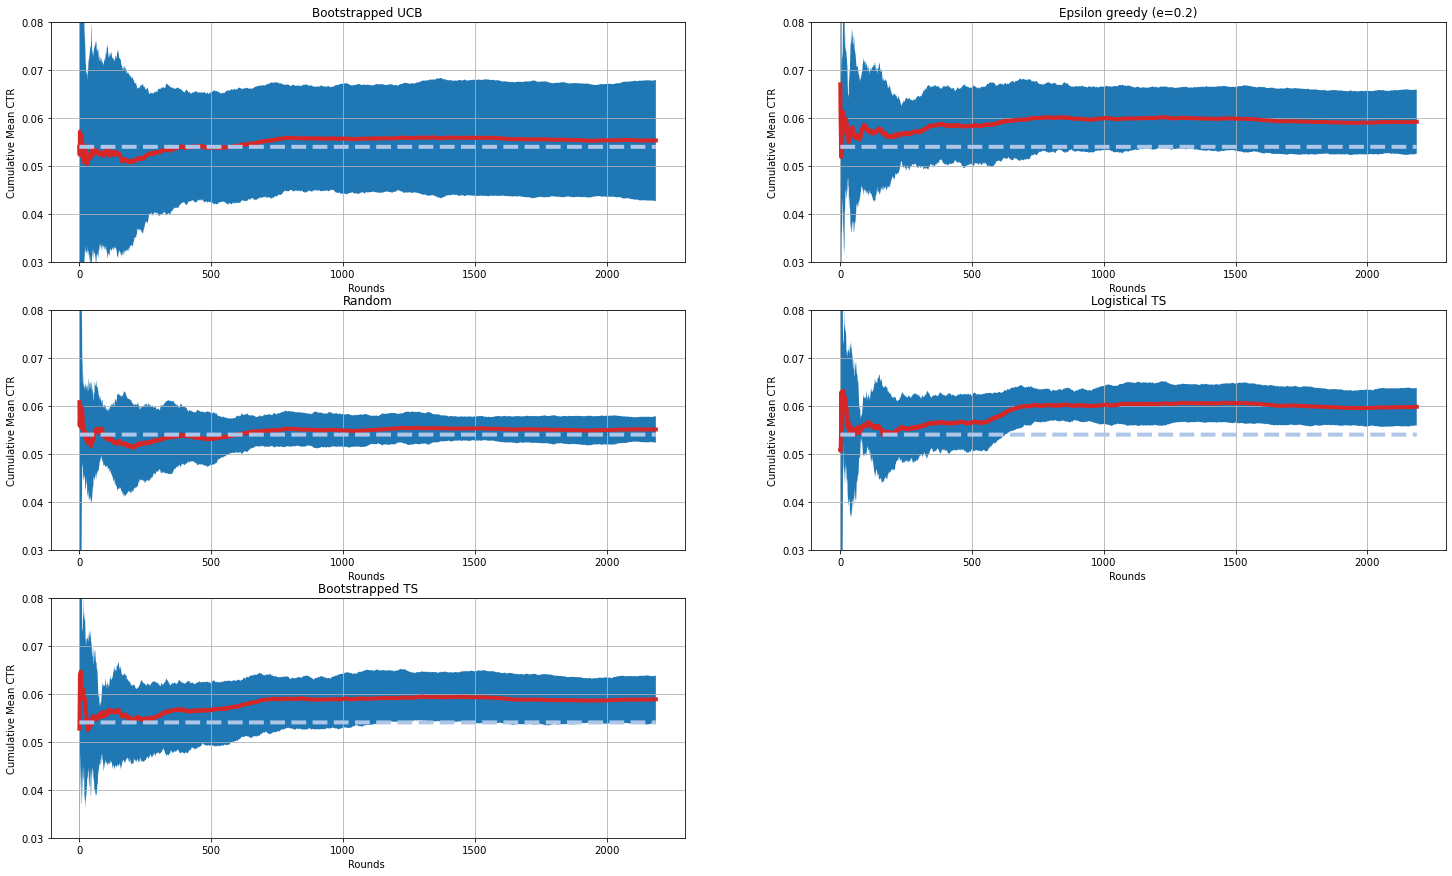

In [50]:
from contextualbandits.evaluation import evaluateRejectionSampling
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 25, 15
lwd = 4
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))
x = [i for i in range(len(BootstrappedUCB_lower))]
ax = plt.subplot(3,2,1)
plt.plot(BootstrappedUCB_average,linewidth=lwd,color=colors[6])
plt.plot(np.repeat(np.sum(rewards)/len(rewards),len(BootstrappedTS_average)), label="Overall CTR",linewidth=lwd,color=colors[1],ls='dashed')
plt.fill_between(x,BootstrappedUCB_lower,BootstrappedUCB_upper)
plt.title('Bootstrapped UCB')
plt.ylim((0.03,0.08))
plt.xlabel('Rounds ')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Cumulative Mean CTR')
plt.grid()
ax = plt.subplot(3,2,2)
plt.plot(EpsilonGreedy_average,linewidth=lwd,color=colors[6])
plt.plot(np.repeat(np.sum(rewards)/len(rewards),len(BootstrappedTS_average)), label="Overall CTR",linewidth=lwd,color=colors[1],ls='dashed')
plt.fill_between(x,EpsilonGreedy_lower,EpsilonGreedy_upper)
plt.title('Epsilon greedy (e=0.2)')
plt.ylim((0.03,0.08))
plt.xlabel('Rounds ')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Cumulative Mean CTR')
plt.grid()
ax = plt.subplot(3,2,3)
plt.plot(Random_average,linewidth=lwd,color=colors[6])
plt.plot(np.repeat(np.sum(rewards)/len(rewards),len(BootstrappedTS_average)), label="Overall CTR",linewidth=lwd,color=colors[1],ls='dashed')
plt.fill_between(x,Random_lower,Random_upper)
plt.title('Random')
plt.ylim((0.03,0.08))
plt.xlabel('Rounds ')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Cumulative Mean CTR')
plt.grid()
ax = plt.subplot(3,2,4)
plt.plot(LogisticTS_average,linewidth=lwd,color=colors[6])
plt.plot(np.repeat(np.sum(rewards)/len(rewards),len(BootstrappedTS_average)), label="Overall CTR",linewidth=lwd,color=colors[1],ls='dashed')
plt.fill_between(x,LogisticTS_lower,LogisticTS_upper)
plt.title('Logistical TS')
plt.ylim((0.03,0.08))
plt.xlabel('Rounds ')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Cumulative Mean CTR')
plt.grid()
ax = plt.subplot(3,2,5)
plt.plot(BootstrappedTS_average,linewidth=lwd,color=colors[6])
plt.plot(np.repeat(np.sum(rewards)/len(rewards),len(BootstrappedTS_average)), label="Overall CTR",linewidth=lwd,color=colors[1],ls='dashed')
plt.fill_between(x,BootstrappedTS_lower,LogisticTS_upper)
plt.title('Bootstrapped TS')
plt.ylim((0.03,0.08))
plt.xlabel('Rounds ')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Cumulative Mean CTR')
plt.grid()

